In [241]:
import pandas as pd
import matplotlib.pyplot as plt

In [242]:
data = pd.read_csv("severity_control_processed.csv")

In [243]:
data.head()

,Mod1Id,SexF,Height,Weight,GCSEye,GCSVer,GCSMot,GCSTot,GCS_Severity,GCSTot_Calculated,...,SCI_special,Has_Private_Insurance_special,Has_Government_Insurance_special,SexF_std,Height_std,Weight_std,CC_Hypertension_std,SCI_std,Has_Private_Insurance_std,Has_Government_Insurance_std
0,167,2.0,75.0,236.0,1.0,2.0,4.0,7.0,Severe,7.0,...,0,0,0,0.551808,1.563797,1.538961,-0.860840,-0.228799,1.334220,-0.759911
1,167,2.0,75.0,236.0,1.0,2.0,4.0,7.0,Severe,7.0,...,0,0,0,0.551808,1.563797,1.538961,-0.860840,-0.228799,1.334220,-0.759911
2,221,2.0,70.0,172.0,1.0,2.0,5.0,8.0,Severe,8.0,...,0,0,0,0.551808,0.298558,-0.116995,1.238377,-0.228799,-0.749502,1.315944
3,221,2.0,70.0,172.0,1.0,2.0,5.0,8.0,Severe,8.0,...,0,0,0,0.551808,0.298558,-0.116995,1.238377,-0.228799,-0.749502,1.315944
4,262,2.0,73.0,174.0,1.0,1.0,1.0,3.0,Severe,3.0,...,0,0,0,0.551808,1.057701,-0.065247,0.188769,-0.228799,-0.749502,-0.759911


In [244]:
data['Severity_Group_Binary'] = data['GCS_Severity'].apply(lambda x: 'Severe' if x == 'Severe' else 'Mild/Moderate')

In [245]:
severity_binary_counts = data['Severity_Group_Binary'].value_counts()

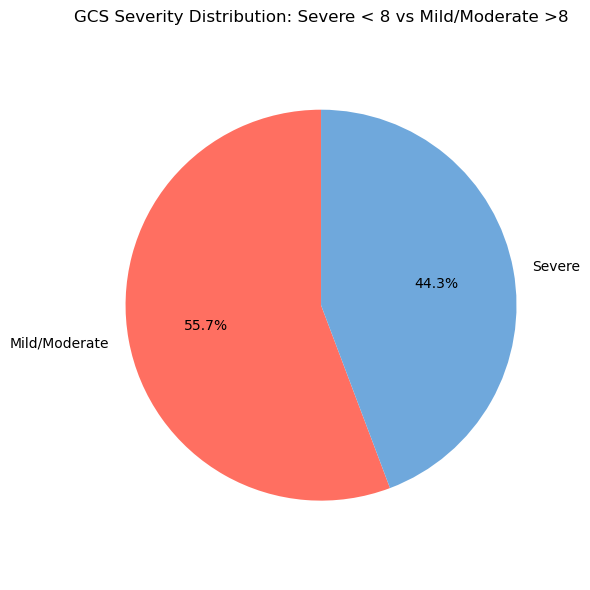

In [246]:
plt.figure(figsize=(6, 6))
plt.pie(severity_binary_counts,
        labels=severity_binary_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff6f61', '#6fa8dc'])  

plt.title('GCS Severity Distribution: Severe < 8 vs Mild/Moderate >8')
plt.axis('equal')
plt.tight_layout()
plt.show()

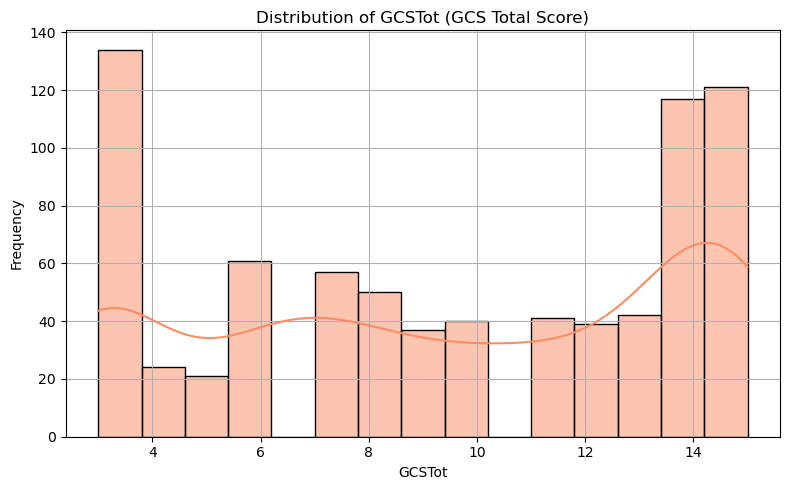

In [247]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(data['GCSTot'], bins=15, kde=True, color='#fc8d62')
plt.title('Distribution of GCSTot (GCS Total Score)')
plt.xlabel('GCSTot')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

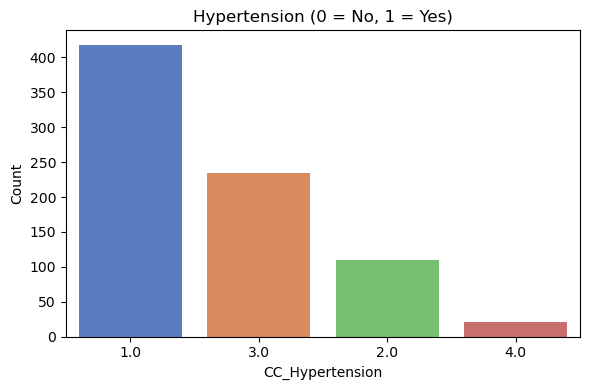

In [248]:
htn_counts = data['CC_Hypertension'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=htn_counts.index.astype(str), y=htn_counts.values, palette='muted')
plt.title('Hypertension (0 = No, 1 = Yes)')
plt.xlabel('CC_Hypertension')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Treatment

In [249]:
craniotomy_counts = data['Required_Craniotomy'].value_counts().sort_index()

In [250]:
total = craniotomy_counts.sum()
craniotomy_percent = (craniotomy_counts / total * 100).round(1)

In [251]:
for val in craniotomy_counts.index:
    label = "Required" if val == 1 else "Not Required"
    print(f"{label} ({val}): {craniotomy_counts[val]} patients ({craniotomy_percent[val]}%)")

Not Required (0): 443 patients (56.5%)
Required (1): 341 patients (43.5%)


# Outcome

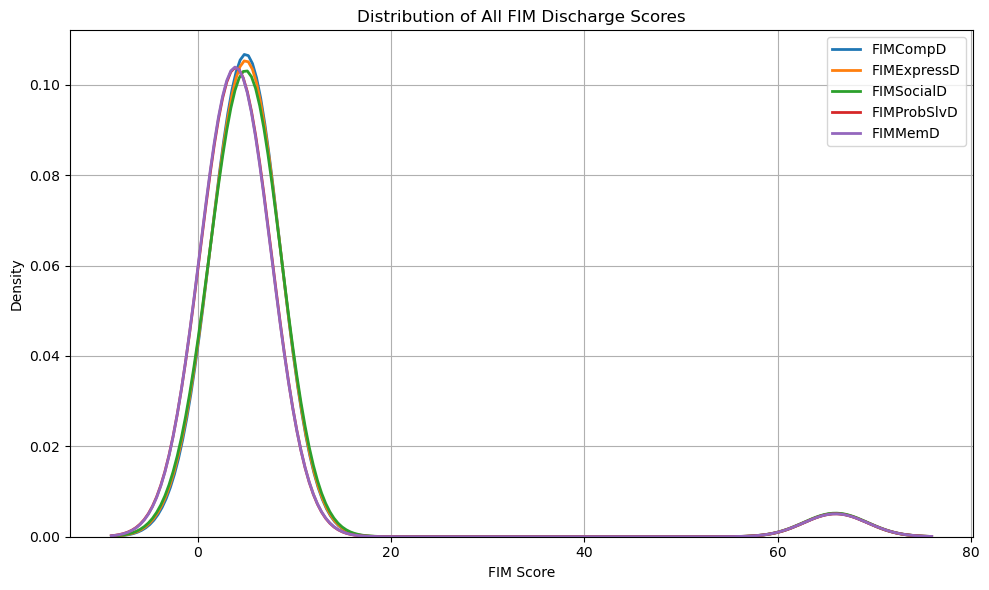

In [252]:
# Set figure size and style
plt.figure(figsize=(10, 6))
sns.kdeplot(data['FIMCompD'], label='FIMCompD', linewidth=2)
sns.kdeplot(data['FIMExpressD'], label='FIMExpressD', linewidth=2)
sns.kdeplot(data['FIMSocialD'], label='FIMSocialD', linewidth=2)
sns.kdeplot(data['FIMProbSlvD'], label='FIMProbSlvD', linewidth=2)
sns.kdeplot(data['FIMMemD'], label='FIMMemD', linewidth=2)

# Customize plot
plt.title('Distribution of All FIM Discharge Scores')
plt.xlabel('FIM Score')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Correlation Matrix across FIM Discharge Scores

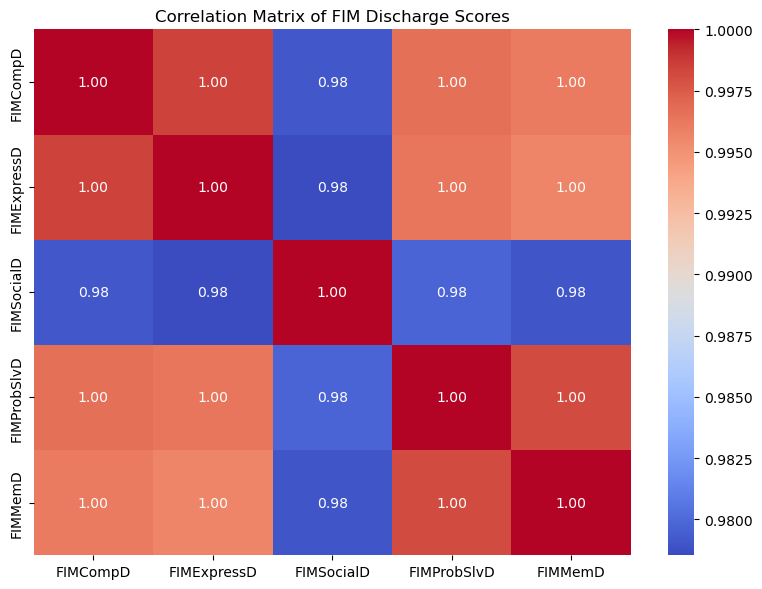

In [253]:
fim_cols = ['FIMCompD', 'FIMExpressD', 'FIMSocialD', 'FIMProbSlvD', 'FIMMemD']
corr_matrix = data[fim_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of FIM Discharge Scores")
plt.tight_layout()
plt.show()

# Plot Confounders vs. treatment

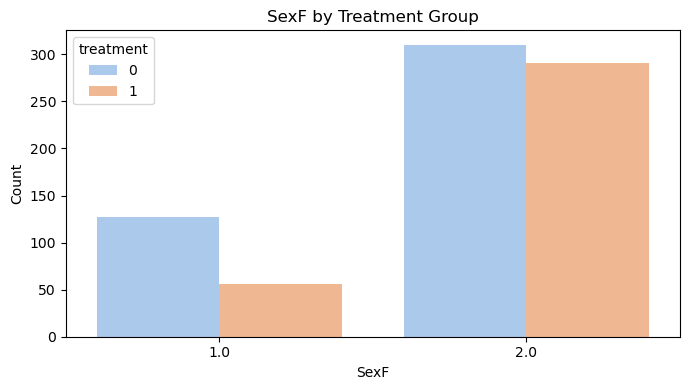

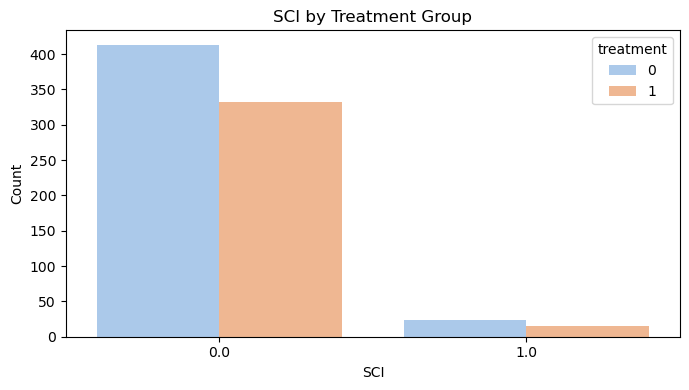

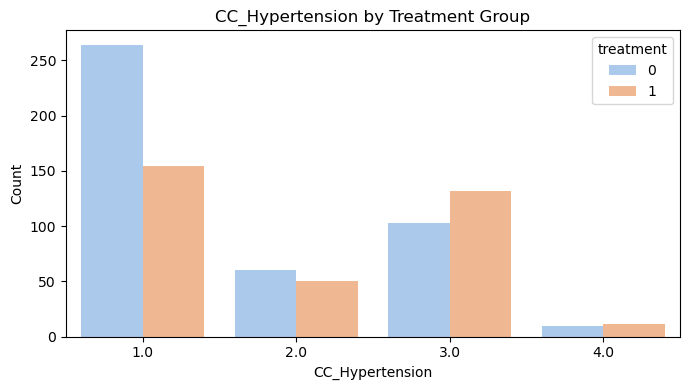

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

confounders = ['SexF', 'SCI', 'CC_Hypertension']

for var in confounders:
    plt.figure(figsize=(7, 4))
    if data[var].nunique() <= 5:  
        sns.countplot(x=var, hue='treatment', data=data, palette='pastel')
        plt.title(f'{var} by Treatment Group')
        plt.ylabel('Count')
    else:  # Continuous
        sns.boxplot(x='treatment', y=var, data=data, palette='Set2')
        plt.title(f'{var} Distribution by Treatment')
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()

In [255]:
print(data['treatment'].value_counts())

treatment
0    437
1    347
Name: count, dtype: int64


# Group Stratification

In [256]:
data_severe = data.copy()

# Compute Stratified ATE for FIMCompD

In [257]:
data_causal = data_severe[['treatment', 'FIMCompD', 'SexF', 'SCI', 'CC_Hypertension']].copy()
data_causal['SexF'] = data_causal['SexF'].astype(int)
data_causal['SCI'] = data_causal['SCI'].astype(int)
data_causal['CC_Hypertension'] = data_causal['CC_Hypertension'].astype(int)

data_causal['Group'] = (
    data_causal['SexF'].astype(str) + "_" +
    data_causal['SCI'].astype(str) + "_" +
    data_causal['CC_Hypertension'].astype(str)
)

group_counts = data_causal['Group'].value_counts(normalize=True)

group_means = data_causal.groupby(['Group', 'treatment'])['FIMCompD'].mean().unstack()

ate = 0
for group in group_counts.index:
    p_w = group_counts[group]
    y1 = group_means.get(1, pd.Series()).get(group, 0)
    y0 = group_means.get(0, pd.Series()).get(group, 0)
    if pd.notna(y1) and pd.notna(y0):
        ate += (y1 - y0) * p_w

In [258]:
print(f"Estimated ATE of surgery for FIMComD: {ate:.2f}")

Estimated ATE of surgery for FIMComD: -1.27


In [259]:
print(data_causal.columns)
print(data_causal.head())

Index(['treatment', 'FIMCompD', 'SexF', 'SCI', 'CC_Hypertension', 'Group'], dtype='object')
   treatment  FIMCompD  SexF  SCI  CC_Hypertension  Group
0          1       6.0     2    0                1  2_0_1
1          1       6.0     2    0                1  2_0_1
2          1       6.0     2    0                3  2_0_3
3          1       6.0     2    0                3  2_0_3
4          1       6.0     2    0                2  2_0_2


# Compute Stratified ATE for FIMMemD

In [260]:
data_severe = data.copy()
data_causal = data_severe[['treatment', 'FIMMemD', 'SexF', 'SCI', 'CC_Hypertension']].copy()
data_causal['SexF'] = data_causal['SexF'].astype(int)
data_causal['SCI'] = data_causal['SCI'].astype(int)
data_causal['CC_Hypertension'] = data_causal['CC_Hypertension'].astype(int)

data_causal['Group'] = (
    data_causal['SexF'].astype(str) + "_" +
    data_causal['SCI'].astype(str) + "_" +
    data_causal['CC_Hypertension'].astype(str)
)

group_counts = data_causal['Group'].value_counts(normalize=True)

group_means = data_causal.groupby(['Group', 'treatment'])['FIMMemD'].mean().unstack()

ate = 0
for group in group_counts.index:
    p_w = group_counts[group]
    y1 = group_means.get(1, pd.Series()).get(group, 0)
    y0 = group_means.get(0, pd.Series()).get(group, 0)
    if pd.notna(y1) and pd.notna(y0):
        ate += (y1 - y0) * p_w

In [261]:
print(f"Estimated ATE of surgery for FIMMemD: {ate:.2f}")

Estimated ATE of surgery for FIMMemD: -1.14


In [262]:
print(data_causal.columns)
print(data_causal.head())

Index(['treatment', 'FIMMemD', 'SexF', 'SCI', 'CC_Hypertension', 'Group'], dtype='object')
   treatment  FIMMemD  SexF  SCI  CC_Hypertension  Group
0          1      6.0     2    0                1  2_0_1
1          1      6.0     2    0                1  2_0_1
2          1      6.0     2    0                3  2_0_3
3          1      6.0     2    0                3  2_0_3
4          1      4.0     2    0                2  2_0_2


# Compute Stratified ATE for FIMMemD

In [263]:
data_severe = data.copy()
data_causal = data_severe[['treatment', 'FIMProbSlvD', 'SexF', 'SCI', 'CC_Hypertension']].copy()
data_causal['SexF'] = data_causal['SexF'].astype(int)
data_causal['SCI'] = data_causal['SCI'].astype(int)
data_causal['CC_Hypertension'] = data_causal['CC_Hypertension'].astype(int)

data_causal['Group'] = (
    data_causal['SexF'].astype(str) + "_" +
    data_causal['SCI'].astype(str) + "_" +
    data_causal['CC_Hypertension'].astype(str)
)

group_counts = data_causal['Group'].value_counts(normalize=True)

group_means = data_causal.groupby(['Group', 'treatment'])['FIMProbSlvD'].mean().unstack()

ate = 0
for group in group_counts.index:
    p_w = group_counts[group]
    y1 = group_means.get(1, pd.Series()).get(group, 0)
    y0 = group_means.get(0, pd.Series()).get(group, 0)
    if pd.notna(y1) and pd.notna(y0):
        ate += (y1 - y0) * p_w

In [264]:
print(f"Estimated ATE of surgery for FIMProbSlvD: {ate:.2f}")

Estimated ATE of surgery for FIMProbSlvD: -1.21


In [265]:
print(data_causal.columns)
print(data_causal.head())

Index(['treatment', 'FIMProbSlvD', 'SexF', 'SCI', 'CC_Hypertension', 'Group'], dtype='object')
   treatment  FIMProbSlvD  SexF  SCI  CC_Hypertension  Group
0          1          6.0     2    0                1  2_0_1
1          1          6.0     2    0                1  2_0_1
2          1          3.0     2    0                3  2_0_3
3          1          3.0     2    0                3  2_0_3
4          1          4.0     2    0                2  2_0_2


# Compute Stratified ATE for FIMExpressD

In [266]:
data_severe = data.copy()
data_causal = data_severe[['treatment', 'FIMExpressD', 'SexF', 'SCI', 'CC_Hypertension']].copy()
data_causal['SexF'] = data_causal['SexF'].astype(int)
data_causal['SCI'] = data_causal['SCI'].astype(int)
data_causal['CC_Hypertension'] = data_causal['CC_Hypertension'].astype(int)

data_causal['Group'] = (
    data_causal['SexF'].astype(str) + "_" +
    data_causal['SCI'].astype(str) + "_" +
    data_causal['CC_Hypertension'].astype(str)
)

group_counts = data_causal['Group'].value_counts(normalize=True)

group_means = data_causal.groupby(['Group', 'treatment'])['FIMExpressD'].mean().unstack()

ate = 0
for group in group_counts.index:
    p_w = group_counts[group]
    y1 = group_means.get(1, pd.Series()).get(group, 0)
    y0 = group_means.get(0, pd.Series()).get(group, 0)
    if pd.notna(y1) and pd.notna(y0):
        ate += (y1 - y0) * p_w

In [267]:
print(f"Estimated ATE of surgery for FIMExpressD: {ate:.2f}")

Estimated ATE of surgery for FIMExpressD: -1.39


In [268]:
print(data_causal.columns)
print(data_causal.head())

Index(['treatment', 'FIMExpressD', 'SexF', 'SCI', 'CC_Hypertension', 'Group'], dtype='object')
   treatment  FIMExpressD  SexF  SCI  CC_Hypertension  Group
0          1          6.0     2    0                1  2_0_1
1          1          6.0     2    0                1  2_0_1
2          1          4.0     2    0                3  2_0_3
3          1          4.0     2    0                3  2_0_3
4          1          6.0     2    0                2  2_0_2


# Compute Stratified ATE for FIMSocialD

In [269]:
data_severe = data.copy()
data_causal = data_severe[['treatment', 'FIMSocialD', 'SexF', 'SCI', 'CC_Hypertension']].copy()
data_causal['SexF'] = data_causal['SexF'].astype(int)
data_causal['SCI'] = data_causal['SCI'].astype(int)
data_causal['CC_Hypertension'] = data_causal['CC_Hypertension'].astype(int)

data_causal['Group'] = (
    data_causal['SexF'].astype(str) + "_" +
    data_causal['SCI'].astype(str) + "_" +
    data_causal['CC_Hypertension'].astype(str)
)

group_counts = data_causal['Group'].value_counts(normalize=True)

group_means = data_causal.groupby(['Group', 'treatment'])['FIMSocialD'].mean().unstack()

ate = 0
for group in group_counts.index:
    p_w = group_counts[group]
    y1 = group_means.get(1, pd.Series()).get(group, 0)
    y0 = group_means.get(0, pd.Series()).get(group, 0)
    if pd.notna(y1) and pd.notna(y0):
        ate += (y1 - y0) * p_w

In [270]:
print(f"Estimated ATE of surgery for FIMSocialD: {ate:.2f}")

Estimated ATE of surgery for FIMSocialD: -1.11


In [271]:
print(data_causal.columns)
print(data_causal.head())

Index(['treatment', 'FIMSocialD', 'SexF', 'SCI', 'CC_Hypertension', 'Group'], dtype='object')
   treatment  FIMSocialD  SexF  SCI  CC_Hypertension  Group
0          1         6.0     2    0                1  2_0_1
1          1         6.0     2    0                1  2_0_1
2          1         5.0     2    0                3  2_0_3
3          1         5.0     2    0                3  2_0_3
4          1         4.0     2    0                2  2_0_2


In [272]:
#################################################################################################################

# ATT (Average Treatment effect on the Treated)

In [273]:
data['Severity_Group'] = data['GCSTot'].apply(lambda x: 'Severe' if x <= 8 else 'Mild/Moderate')

In [274]:
data['Did_Surgery'] = data['Craniotomy'].apply(lambda x: 1 if x in [2, 3, 4] else 0)

In [275]:
severity_surgery_counts = pd.crosstab(data['Severity_Group'], data['Did_Surgery'], margins=True)
severity_surgery_counts.columns = ['No Surgery', 'Did Surgery', 'All']

In [276]:
print(severity_surgery_counts)

                No Surgery  Did Surgery  All
Severity_Group                              
Mild/Moderate          258          179  437
Severe                 185          162  347
All                    443          341  784


In the following we will have the effect of surgery (treatment) on those who actually received surgery, within the Severe TBI group only.

In [277]:
data_severe= data[data['GCSTot'] <= 8].copy()

In [278]:
data_severe['treatment'] = data_severe['Craniotomy'].apply(lambda x: 1 if x in [2, 3, 4] else 0)

In [279]:
data_severe['Group'] = data_severe[['SexF', 'SCI', 'CC_Hypertension']].astype(str).agg('_'.join, axis=1)

In [280]:
def compute_stratified_att(data, outcome):
    treated = data[data['treatment'] == 1]
    group_weights = treated['Group'].value_counts(normalize=True)
    group_means = data.groupby(['Group', 'treatment'])[outcome].mean().unstack()

    att = 0
    valid_groups = 0
    for group in group_weights.index:
        if 1 in group_means.columns and 0 in group_means.columns:
            y1 = group_means.loc[group, 1] if group in group_means.index else np.nan
            y0 = group_means.loc[group, 0] if group in group_means.index else np.nan
            if pd.notna(y1) and pd.notna(y0):
                effect = y1 - y0
                weight = group_weights[group]
                att += effect * weight
                valid_groups += 1

    return att

outcome = 'FIMCompD' 
att_result = compute_stratified_att(data_severe, outcome)
print(f"Estimated ATT on {outcome}: {att_result:.2f}")

Estimated ATT on FIMCompD: -2.49


In [281]:
def compute_stratified_att(data, outcome):
    treated = data[data['treatment'] == 1]
    group_weights = treated['Group'].value_counts(normalize=True)
    group_means = data.groupby(['Group', 'treatment'])[outcome].mean().unstack()

    att = 0
    valid_groups = 0
    for group in group_weights.index:
        if 1 in group_means.columns and 0 in group_means.columns:
            y1 = group_means.loc[group, 1] if group in group_means.index else np.nan
            y0 = group_means.loc[group, 0] if group in group_means.index else np.nan
            if pd.notna(y1) and pd.notna(y0):
                effect = y1 - y0
                weight = group_weights[group]
                att += effect * weight
                valid_groups += 1

    return att

outcome = 'FIMMemD' 
att_result = compute_stratified_att(data_severe, outcome)
print(f"Estimated ATT on {outcome}: {att_result:.2f}")

Estimated ATT on FIMMemD: -2.12


In [282]:
def compute_stratified_att(data, outcome):
    treated = data[data['treatment'] == 1]
    group_weights = treated['Group'].value_counts(normalize=True)
    group_means = data.groupby(['Group', 'treatment'])[outcome].mean().unstack()

    att = 0
    valid_groups = 0
    for group in group_weights.index:
        if 1 in group_means.columns and 0 in group_means.columns:
            y1 = group_means.loc[group, 1] if group in group_means.index else np.nan
            y0 = group_means.loc[group, 0] if group in group_means.index else np.nan
            if pd.notna(y1) and pd.notna(y0):
                effect = y1 - y0
                weight = group_weights[group]
                att += effect * weight
                valid_groups += 1

    return att

outcome = 'FIMSocialD' 
att_result = compute_stratified_att(data_severe, outcome)
print(f"Estimated ATT on {outcome}: {att_result:.2f}")

Estimated ATT on FIMSocialD: -2.26


In [283]:
def compute_stratified_att(data, outcome):
    treated = data[data['treatment'] == 1]
    group_weights = treated['Group'].value_counts(normalize=True)
    group_means = data.groupby(['Group', 'treatment'])[outcome].mean().unstack()

    att = 0
    valid_groups = 0
    for group in group_weights.index:
        if 1 in group_means.columns and 0 in group_means.columns:
            y1 = group_means.loc[group, 1] if group in group_means.index else np.nan
            y0 = group_means.loc[group, 0] if group in group_means.index else np.nan
            if pd.notna(y1) and pd.notna(y0):
                effect = y1 - y0
                weight = group_weights[group]
                att += effect * weight
                valid_groups += 1

    return att

outcome = 'FIMProbSlvD' 
att_result = compute_stratified_att(data_severe, outcome)
print(f"Estimated ATT on {outcome}: {att_result:.2f}")

Estimated ATT on FIMProbSlvD: -2.35


In [284]:
def compute_stratified_att(data, outcome):
    treated = data[data['treatment'] == 1]
    group_weights = treated['Group'].value_counts(normalize=True)
    group_means = data.groupby(['Group', 'treatment'])[outcome].mean().unstack()

    att = 0
    valid_groups = 0
    for group in group_weights.index:
        if 1 in group_means.columns and 0 in group_means.columns:
            y1 = group_means.loc[group, 1] if group in group_means.index else np.nan
            y0 = group_means.loc[group, 0] if group in group_means.index else np.nan
            if pd.notna(y1) and pd.notna(y0):
                effect = y1 - y0
                weight = group_weights[group]
                att += effect * weight
                valid_groups += 1

    return att

outcome = 'FIMExpressD' 
att_result = compute_stratified_att(data_severe, outcome)
print(f"Estimated ATT on {outcome}: {att_result:.2f}")

Estimated ATT on FIMExpressD: -2.43


In [285]:
#######################################################################################

# Validation_ATT_Welch’s t-test

In [286]:
from scipy.stats import ttest_ind

fim_outcomes = ['FIMCompD', 'FIMMemD', 'FIMProbSlvD', 'FIMExpressD', 'FIMSocialD']

for outcome in fim_outcomes:
    valid_groups = data_severe.groupby(['Group', 'treatment']).size().unstack().dropna().index.get_level_values(0).unique()
    valid_data = data_severe[data_severe['Group'].isin(valid_groups)]
    treated = valid_data[valid_data['treatment'] == 1][outcome]
    control = valid_data[valid_data['treatment'] == 0][outcome]

    t_stat, p_val = ttest_ind(treated, control, equal_var=False)

    print(f"\nT-test for {outcome}:")
    print(f"Mean Treated: {treated.mean():.2f}, Mean Control: {control.mean():.2f}")
    print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")


T-test for FIMCompD:
Mean Treated: 5.98, Mean Control: 7.46
T-statistic: -1.15, p-value: 0.2522

T-test for FIMMemD:
Mean Treated: 5.42, Mean Control: 6.38
T-statistic: -0.73, p-value: 0.4637

T-test for FIMProbSlvD:
Mean Treated: 5.25, Mean Control: 6.42
T-statistic: -0.89, p-value: 0.3727

T-test for FIMExpressD:
Mean Treated: 5.94, Mean Control: 7.28
T-statistic: -1.04, p-value: 0.3008

T-test for FIMSocialD:
Mean Treated: 6.16, Mean Control: 7.58
T-statistic: -1.07, p-value: 0.2866
